# Task 1

## Problem Statement
Implement, on a quantum simulator of your choice, the following 4 qubits state $|\psi(\theta)>$:

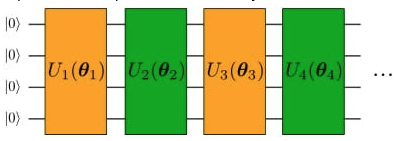

Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:


Even blocks:
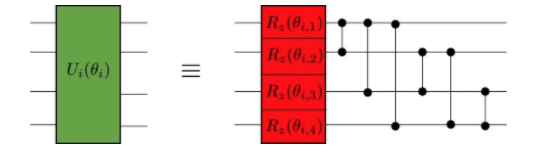


Odd blocks:
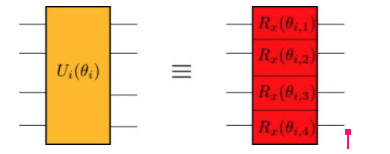



The angles $\theta_{i,n}$ are variational parameters, lying in the interval $(0, 2\pi)$, initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$$
\varepsilon=\min _{\theta}\||\psi(\theta)>-| \varphi>\|
$$

Where $| \varphi>$ is a randomly generated vector on 4 qubits and the norm $|| | v> ||$, of a state $| v>$, simply denotes the sum of the squares of the components of $|v >$. The right set of parameters $i,n$ can be found via any method of choice (e.g. grid-search or gradient descent)

## Solution

We want to find how the cost function $\varepsilon$ changes with the increase in number of layers, when each layer has the most optimal set of weights.


We can use optimizers from [Pennylane](https://pennylane.ai/) to find the most optimal weights at each layer.

In [9]:
%matplotlib inline
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os

### Step 1: Set configuration values

We set the default values for the number of layers, qubits and optimization steps. We set an output directory for where we want to store the results of our experiment

In [10]:
NUM_LAYERS = 1
NUM_QUBITS = 4
NUM_STEPS = 50

STEP_SIZE = 0.1

OUTPUT_DIR = "./output/"

qpu = qml.device("default.qubit", wires=NUM_QUBITS)

We generate the random state vector that we want to optimize for

In [11]:
psi = np.random.rand(2**NUM_QUBITS)
while sum(psi) !=1:
    psi = np.random.rand(2**NUM_QUBITS)
    psi = np.exp(psi) / sum(np.exp(psi))

print(psi)

[0.05843349 0.06447952 0.04830286 0.08492237 0.06623436 0.06352148
 0.07338797 0.04596564 0.05579612 0.07591793 0.0833477  0.08754031
 0.06700456 0.04107394 0.04242883 0.04164292]


### Step 2: Define helper function for generating circuit

The params for each layer are indexed as ```params[layer_index * total_qubits + qubit_under_consideration]```


In [12]:
@qml.qnode(qpu)
def circuit(params):

    global NUM_LAYERS
    global NUM_QUBITS
    
    for layer in range(NUM_LAYERS):
        for wire in range(NUM_QUBITS):
            qml.RZ(params[layer * NUM_QUBITS + wire] * np.pi, wires=wire)
            
        for control in range(NUM_QUBITS-1):
            for target in range(control+1, NUM_QUBITS):
                qml.CZ(wires=[control,target]) 
        
        for wire in range(NUM_QUBITS):
            qml.RX(params[layer * NUM_QUBITS + wire] * np.pi, wires=wire)

    return qml.probs(np.arange(NUM_QUBITS))

let's verify that the single layer circuit we can generate using the above function is the circuit we want

In [13]:
weights = np.random.rand(NUM_LAYERS * NUM_QUBITS)
circuit(weights)
print(circuit.draw())

 0: ──RZ(2.469)──╭C──╭C──────╭C───RX(2.469)────────────────────────╭┤ Probs 
 1: ──RZ(2.264)──╰Z──│───╭C──│───╭C───────────RX(2.264)────────────├┤ Probs 
 2: ──RZ(0.85)───────╰Z──╰Z──│───│───────────╭C──────────RX(0.85)──├┤ Probs 
 3: ──RZ(0.2)────────────────╰Z──╰Z──────────╰Z──────────RX(0.2)───╰┤ Probs 



### Step 3: Define the cost function


The cost function we want to use is $$\Sigma_{i=1}^{2^n}({\psi_i - \varepsilon_i})^2$$


In [14]:
def cost(x):
    return np.sum(np.square(circuit(x) - psi))

### Step 4: Optimize to find best parameters

Saving output to ./output/1600070695.867525


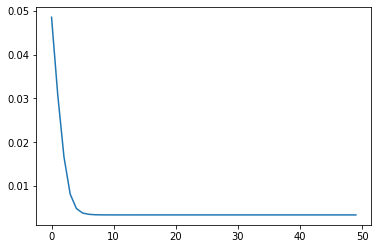

Number of layers: 1, Optimal cost: 0.003415901591994985, Time: 1.2083940505981445s


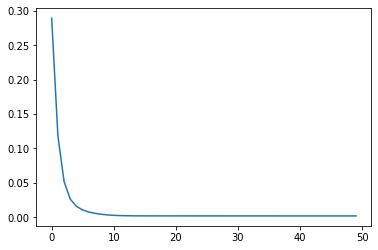

Number of layers: 2, Optimal cost: 0.0020295489242570363, Time: 3.450861930847168s


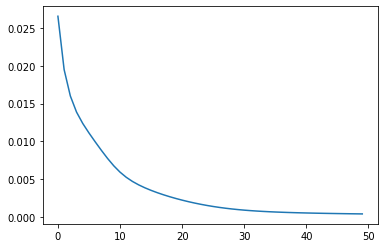

Number of layers: 4, Optimal cost: 0.00036617414111220377, Time: 11.007598161697388s


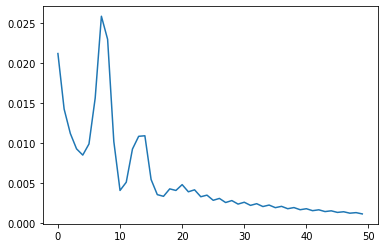

Number of layers: 8, Optimal cost: 0.0010974032516942542, Time: 44.83785796165466s


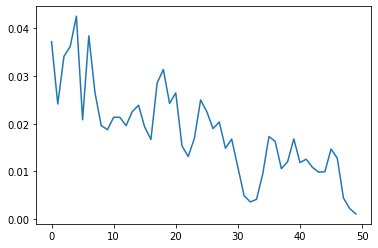

Number of layers: 16, Optimal cost: 0.00107690049575142, Time: 150.60688281059265s


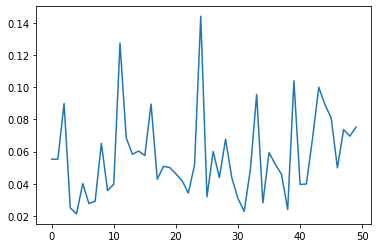

Number of layers: 32, Optimal cost: 0.07524433332486875, Time: 630.9296607971191s


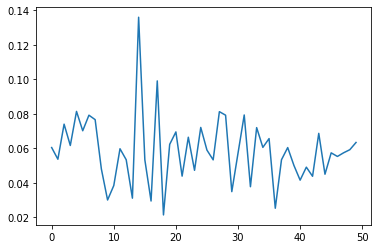

Number of layers: 64, Optimal cost: 0.06340871345932804, Time: 2331.018049955368s


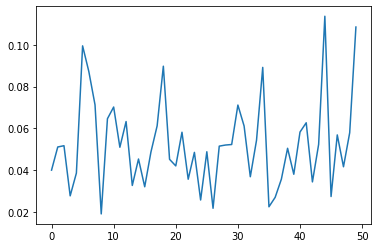

Number of layers: 128, Optimal cost: 0.10841433497972812, Time: 8919.046957731247s


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [7]:
loss = []
times = []

overall_begin = time.time()

output_file_path = os.path.join(OUTPUT_DIR, str(overall_begin))
os.mkdir(output_file_path)

print(f"Saving output to {output_file_path}")

for layers in range(3,10):
    # We use the gradient descent optimizer
    opt = qml.GradientDescentOptimizer(stepsize=STEP_SIZE)
    
    # Iterate through powers of 2
    NUM_LAYERS=2**layers
    
    # Randomly initialize weights
    params = np.random.uniform(low=0, high=2, size=NUM_LAYERS * NUM_QUBITS)

    local_loss = []
    begin = time.time()
    for i in range(NUM_STEPS):
        params = opt.step(cost, params)
        local_loss.append(cost(params))
    end = time.time()

    # Plot the loss for this layer
    plt.plot(local_loss)
    plt.show()
    plt.savefig(os.path.join(output_file_path, str(NUM_LAYERS) + ".png"))
    plt.clf()
    
    # Save the most optimal circuit
    with open(os.path.join(output_file_path, str(NUM_LAYERS) + ".circuit"), 'w') as fp:
        circuit(params)
        fp.write(circuit.draw())
    
    local_runtime = end - begin
    times.append(local_runtime)
    
    loss.append((NUM_LAYERS, local_loss[-1]))
    print("Number of layers: {}, Optimal cost: {}, Time: {}s".format(NUM_LAYERS, local_loss[-1], local_runtime))

In [ ]:
overall_end = time.time()
print(f"Total time taken: {round(overall_end-overall_begin, 2)}s")

# Plot all the losses as a function of the layers
plt.grid(True)
plt.plot(*list(zip(*loss)))
plt.savefig(os.path.join(output_file_path, "overall.png"))

## References
- [Qubit Rotation](https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html)
- [Quantum Natural Gradient](https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html)